In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [ ]:
ml_data = pd.read_csv(
    "../data/icicibank_ml_dataset.csv",
    index_col=0,
    parse_dates=True
)

ml_data.head()


,return,sma_20,sma_50,rsi,volatility,nifty_return,nifty_volatility,banknifty_return,target
date,,,,,,,,,
2019-03-12,0.032859,354.7550,360.878,72.582793,0.016721,0.011922,0.006495,0.017058,1
2019-03-13,0.009531,357.1350,361.441,74.134349,0.013080,0.003584,0.005876,0.015490,0
2019-03-14,-0.010207,359.5425,361.907,69.551914,0.013530,0.000137,0.005552,0.001343,1
2019-03-15,0.019077,362.1100,362.548,72.890447,0.013727,0.007370,0.005141,0.015847,1
2019-03-18,0.006957,364.9050,363.205,74.030047,0.013831,0.003094,0.005196,0.007306,1


In [90]:
ml_data[[
    "return", "sma_20", "sma_50", "rsi", "volatility",
    "nifty_return", "nifty_volatility", "banknifty_return", "target"
]].head()

,return,sma_20,sma_50,rsi,volatility,nifty_return,nifty_volatility,banknifty_return,target
date,,,,,,,,,
2019-03-12,0.032859,354.7550,360.878,72.582793,0.016721,0.011922,0.006495,0.017058,1
2019-03-13,0.009531,357.1350,361.441,74.134349,0.013080,0.003584,0.005876,0.015490,0
2019-03-14,-0.010207,359.5425,361.907,69.551914,0.013530,0.000137,0.005552,0.001343,1
2019-03-15,0.019077,362.1100,362.548,72.890447,0.013727,0.007370,0.005141,0.015847,1
2019-03-18,0.006957,364.9050,363.205,74.030047,0.013831,0.003094,0.005196,0.007306,1


In [91]:
price_data = pd.read_csv(
    "data/icicibank.csv"
)

# normalize columns
price_data.columns = price_data.columns.str.strip().str.lower()

# ensure date index
if "date" in price_data.columns:
    price_data["date"] = pd.to_datetime(price_data["date"])
    price_data.set_index("date", inplace=True)

price_data = price_data.sort_index()

price_data.head()


C:\Users\Shris\AppData\Local\Temp\ipykernel_420\1655190714.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data["date"] = pd.to_datetime(price_data["date"])


,series,open,high,low,prev. close,ltp,close,vwap,52w h,52w l,volume,value,no. of trades,unnamed: 14
date,,,,,,,,,,,,,,
2019-01-01,EQ,361.5,364.8,356.4,360.15,364.2,363.75,360.35,375.3,256.5,7759872,"2,79,63,07,882.85",65606﻿,SERIES
2019-01-02,EQ,361.5,367.9,360.3,363.75,364.3,364.6,364.87,375.3,256.5,18243156,"6,65,63,64,660.40",133500,NaN
2019-01-03,EQ,365,367.3,362.05,364.6,362.1,363.25,365.31,375.3,256.5,12884409,"4,70,68,46,631.45",114828,NaN
2019-01-04,EQ,361.85,368.8,358.05,363.25,366.35,365.2,362.95,375.3,256.5,22896026,"8,31,01,66,817.60",173791,NaN
2019-01-07,EQ,367.5,371,366.55,365.2,367.65,367.7,369.12,375.3,256.5,12719847,"4,69,51,25,833.60",123595,NaN


In [92]:
common_index = ml_data.index.intersection(price_data.index)

ml_data = ml_data.loc[common_index]
price_data = price_data.loc[common_index]


In [93]:
selected_features = [
    "return",
    "sma_20",
    "sma_50",
    "rsi",
    "volatility",
    "nifty_return",
    "nifty_volatility",
    "banknifty_return"
]

X = ml_data[selected_features]
y = ml_data["target"]
prices = price_data["close"]


In [94]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
prices_test = prices.iloc[split_idx:]


In [95]:
print(len(X_test), len(prices_test))

338 338


In [96]:
model = joblib.load("models/rf_icicibank.pkl")

probs = model.predict_proba(X_test)[:, 1]


In [97]:
prices_test = pd.to_numeric(prices_test.astype(str).str.replace(',', ''), errors='coerce')
returns = prices_test.pct_change().fillna(0)

thresholds = np.arange(0.45, 0.70, 0.01)
records = []

for t in thresholds:
    signals = (probs > t).astype(int)
    strat_returns = returns * signals

    sharpe = np.sqrt(252) * strat_returns.mean() / (strat_returns.std() + 1e-8)
    total_return = (1 + strat_returns).cumprod().iloc[-1] - 1

    records.append((t, sharpe, total_return))

opt_df = pd.DataFrame(records, columns=["threshold", "sharpe", "total_return"])
opt_df.sort_values("sharpe", ascending=False).head()

,threshold,sharpe,total_return
7,0.52,0.752518,0.108757
0,0.45,0.667812,0.130160
1,0.46,0.522232,0.095317
6,0.51,0.456932,0.063617
2,0.47,0.362958,0.059414


In [98]:
best_threshold = opt_df.sort_values("sharpe", ascending=False).iloc[0]["threshold"]
best_threshold


np.float64(0.52)

In [99]:
holding_period = 5

signals = (probs > best_threshold).astype(int)
signals = pd.Series(signals, index=returns.index)

strategy_returns = (
    returns.rolling(holding_period).sum()
    * signals.shift(1)
).fillna(0)


In [100]:
transaction_cost = 0.001  # 0.1%

trade_changes = signals.diff().abs()
strategy_returns -= trade_changes * transaction_cost


In [101]:
equity_curve = (1 + strategy_returns).cumprod()
buy_hold_curve = (1 + returns).cumprod()


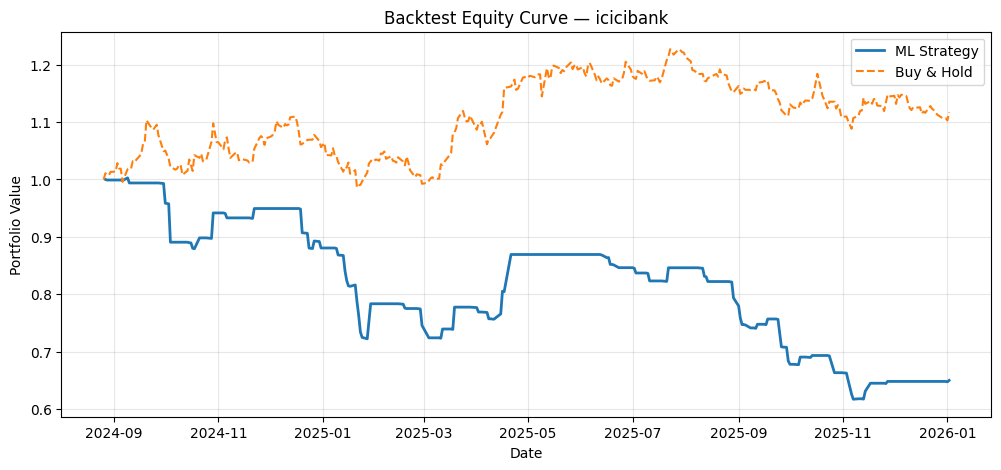

In [102]:
plt.figure(figsize=(12,5))
plt.plot(equity_curve, label="ML Strategy", linewidth=2)
plt.plot(buy_hold_curve, label="Buy & Hold", linestyle="--")
plt.title("Backtest Equity Curve — icicibank")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [103]:
def sharpe_ratio(r):
    return np.sqrt(252) * r.mean() / (r.std() + 1e-8)

print("ML Strategy Return:", f"{equity_curve.iloc[-1]-1:.2%}")
print("ML Sharpe:", round(sharpe_ratio(strategy_returns), 2))

print("Buy & Hold Return:", f"{buy_hold_curve.iloc[-1]-1:.2%}")


ML Strategy Return: -35.01%
ML Sharpe: -1.59
Buy & Hold Return: 11.71%


In [104]:
backtest_df = pd.DataFrame({
    "price": prices_test,
    "signal": signals,
    "returns": returns,
    "strategy_returns": strategy_returns,
    "equity_curve": equity_curve
})

backtest_df.to_csv("results/icicibank_backtest_final.csv")
